In [18]:
import os
from typing import Dict, List, Tuple

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from torch.distributions import Categorical
import math
import torch.nn as nn
import random
from tqdm import tqdm

In [19]:
env = gym.make("Pendulum-v1", render_mode="rgb_array")

device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)

obs_dim = env.observation_space.shape[0]
action_info = env.action_space
max_action = float(env.action_space.high[0])
print(env.observation_space.shape, obs_dim, action_info, max_action)

(3,) 3 Box(-2.0, 2.0, (1,), float32) 2.0


In [20]:
class ReplayBuffer:
    def __init__(self, max_size: int, obs_dim: int, batch_size: int = 32):
        self._obs_buf = np.zeros([max_size, obs_dim], dtype=np.float32)
        self._act_buf = np.zeros([max_size], dtype=np.float32)
        self._reward = np.zeros([max_size], dtype=np.float32)
        self._next_obs_buf = np.zeros([max_size, obs_dim], dtype=np.float32)
        self._done = np.zeros([max_size], dtype=np.float32)
        
        self._index = 0
        self._size = 0
        self._max_size = max_size
        self._batch_size = batch_size
        
    def store(self, obs: np.ndarray, act: np.ndarray, rew: float, next_obs: np.ndarray, done: bool):
        self._obs_buf[self._index] = obs
        self._act_buf[self._index] = act
        self._reward[self._index] = rew
        self._next_obs_buf[self._index] = next_obs
        self._done[self._index] = done
        self._index = (self._index + 1) % self._max_size
        self._size = min(self._size + 1, self._max_size)
        
    def __len__(self) -> int:
        return self._size
    
    def sample(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self._size, size=self._batch_size, replace=False)
        return dict(obs=self._obs_buf[idxs],
                    acts=self._act_buf[idxs],
                    rews=self._reward[idxs],
                    next_obs=self._next_obs_buf[idxs],
                    done=self._done[idxs])

In [21]:
class ActionNetwork(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        """Initialization."""
        super(ActionNetwork, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_dim, 400), 
            nn.ReLU(),
            nn.Linear(400, 300), 
            nn.ReLU(), 
            nn.Linear(300, out_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        return max_action * torch.tanh(self.layers(x))
    
class QValueNetwork(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        '''状态价值，用来评估动作的好坏程度'''
        super(QValueNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_dim + out_dim, 400), 
            nn.ReLU(),
            nn.Linear(400, 300), 
            nn.ReLU(), 
            nn.Linear(300, 1)
        )
        
    def forward(self, x: torch.Tensor, a: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        t = torch.cat([x, a], 1)
        return self.layers(t)

### 使用目标网络

In [22]:
actor = ActionNetwork(obs_dim, 1)
actor_target = ActionNetwork(obs_dim, 1)
actor_target.load_state_dict(actor.state_dict())
actor_optimizer = optim.Adam(actor.parameters(), lr=0.0001)

critic = QValueNetwork(obs_dim, 1)
critic_target = QValueNetwork(obs_dim, 1)
critic_target.load_state_dict(critic.state_dict())
critic_optimizer = optim.Adam(critic.parameters(), lr=0.0001)

buffer = ReplayBuffer(2000, obs_dim, 32)

In [23]:
def critic_value(state, action):
    return critic(state, action)

def critic_target_value(state, action):
    return critic_target(state, action)

def get_action(state):
    action = actor(torch.FloatTensor(state).to(device))
    return action

def get_action_target(state):
    action = actor_target(torch.FloatTensor(state).to(device))
    return action

In [24]:
gamma = 0.98
tau = 0.005
exploration_noise = 0.1

steps = []
scores = []
view_losses = []
max_epoch = 1000
batch_size = 16

for i in tqdm(range(max_epoch)):
    score = 0
    step = 0
    cnt = 1
    
    s, _ = env.reset(seed=3)
    while True:
        '''让策略网络做预测'''
        action = get_action_target(s)
        action = (action.cpu().data.numpy() + np.random.normal(0, exploration_noise, size=env.action_space.shape[0])).clip(
                    env.action_space.low, env.action_space.high)
        next_state, reward, terminated, truncated, _ = env.step(np.float32(action))
        done = terminated or truncated
        
        step += 1
        score += reward
#         print(np.float32(action), reward)
        
        buffer.store(s, action, reward, next_state, 1 - done)
        if done:
            steps.append(step)
            scores.append(score)
            break
        
        s = next_state
    # 结束一轮游戏
    avg_loss = 0
#     print(score, L)
    for j in range(32):
        samples = buffer.sample()
        states = torch.FloatTensor(samples['obs']).to(device)
        actions = torch.FloatTensor(samples['acts']).reshape(-1, 1).to(device)
        rewards = torch.FloatTensor(samples['rews']).reshape(-1, 1).to(device)
        next_states = torch.FloatTensor(samples['next_obs']).to(device)
        masks = torch.LongTensor(samples['done']).reshape(-1, 1).to(device)
#         print(masks.shape)
        '''让价值网络做预测'''
        q_t = critic_value(states, actions)
        next_actions = get_action_target(next_states)
        next_q_t = critic_target_value(next_states, next_actions.to(device))
        '''计算价值网络的 TD 目标和 TD 误差'''
        y_t = rewards + gamma * (next_q_t * masks).mean()
#         print('reward_t:', reward_t.shape, 'y_t:', y_t.shape, 'rewards:', rewards, 'result:', (next_q_t * masks).shape)
        critic_loss = F.mse_loss(q_t, y_t)
        '''更新价值网络'''
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()

        new_acts = get_action(states)
#         print(new_acts)
        actor_loss = critic_value(states, new_acts).mean()
#         print(actor_loss)
#         print('state:', states)
#         print('act:', new_acts)
#         actor_loss = actor_loss.mean()
        avg_loss += actor_loss.item()

        '''更新策略网络'''
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()

        for param, target_param in zip(critic.parameters(), critic_target.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

        for param, target_param in zip(actor.parameters(), actor_target.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)


        cnt += 1
    
    view_losses.append(avg_loss / cnt)
         

100%|██████████| 1000/1000 [05:18<00:00,  3.14it/s]


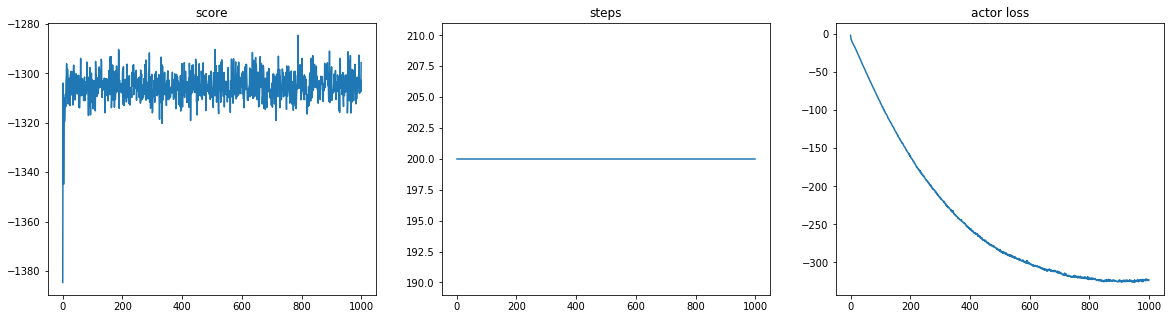

In [27]:
# 观察曲线
plt.figure(figsize=(20, 5))
plt.subplot(131)
# plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
plt.title('score')
plt.plot(scores)
plt.subplot(132)
plt.title('steps')
plt.plot(steps)
plt.subplot(133)
plt.title('actor loss')
plt.plot(view_losses)
plt.show()

In [26]:
# 观察效果
def test():
    dvideo_env = gym.wrappers.RecordVideo(env, video_folder='.')
    state, _ = dvideo_env.reset(seed=3)
    done = False
    score = 0
    step = 0
    while not done:
        action = get_action_target(state)
#         print(action)
        next_state, reward, done, truncated, _ = dvideo_env.step(action)

        state = next_state
        score += reward
        step +=1
        
        if step > 200:
            break

    print("score: ", score, "step:", step)
    dvideo_env.close()
    
test()

/home/ubuntu/anaconda3/lib/python3.7/site-packages/gymnasium/wrappers/record_video.py:88: UserWarning: WARN: Overwriting existing videos at /media/ubuntu/8b2f607c-117a-47e9-b82e-caf4eeeabeca/temp/test/reinforce_learning/policy folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder "


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

### 截断双Q学习

### 向目标策略网络中加入噪声